<a href="https://colab.research.google.com/github/callor/Callor-DeepLearning-2022/blob/master/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
stocks =  pd.read_csv('005930(2012-01-01).KS.csv', header=0)
stocks

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-02,21400,21600,21300,21600,17275.26367,13151350
1,2012-01-03,21860,22100,21840,22100,17675.15430,16927750
2,2012-01-04,22100,22200,21500,21600,17275.26367,17103700
3,2012-01-05,21460,21580,21100,21100,16875.36914,17298400
4,2012-01-06,21120,21320,20600,20800,16635.43359,18816250
...,...,...,...,...,...,...,...
2690,2022-12-08,58700,59200,58600,59200,59200.00000,12986815
2691,2022-12-09,59300,60600,59300,60400,60400.00000,10529632
2692,2022-12-12,59900,60000,59400,59500,59500.00000,9036472
2693,2022-12-13,59600,60300,59400,59700,59700.00000,9040873


 데이터 전처리 및 시각화

In [49]:
# 날짜 칼럼 format 설정
stocks['Date'] = pd.to_datetime(stocks['Date'], format='%Y-%m-%d')
# stocks['Year'] = stocks['Date'].dt.year
stocks = stocks.drop(columns='Adj Close')
stocks

,Date,Open,High,Low,Close,Volume
0,2012-01-02,21400,21600,21300,21600,13151350
1,2012-01-03,21860,22100,21840,22100,16927750
2,2012-01-04,22100,22200,21500,21600,17103700
3,2012-01-05,21460,21580,21100,21100,17298400
4,2012-01-06,21120,21320,20600,20800,18816250
...,...,...,...,...,...,...
2690,2022-12-08,58700,59200,58600,59200,12986815
2691,2022-12-09,59300,60600,59300,60400,10529632
2692,2022-12-12,59900,60000,59400,59500,9036472
2693,2022-12-13,59600,60300,59400,59700,9040873


Text(0, 0.5, 'Volumn')

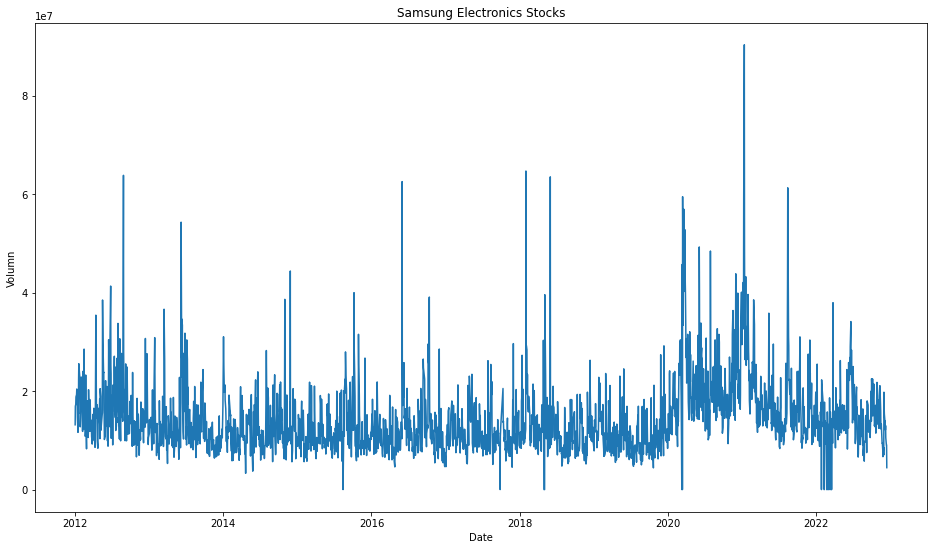

In [50]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stocks['Volume'], x=stocks['Date']).set(title='Samsung Electronics Stocks')
plt.xlabel('Date')
plt.ylabel('Volumn')

2021-1월 89000원대로 주가가 치솟을때  거래량이 피크를 이뤘다다

Text(0, 0.5, 'Price')

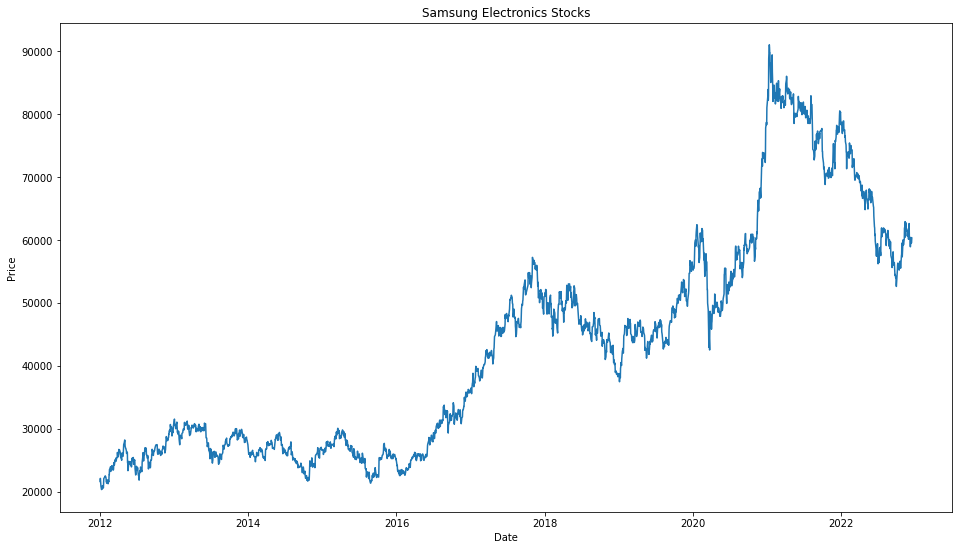

In [52]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stocks['Close'], x=stocks['Date']).set(title='Samsung Electronics Stocks')
plt.xlabel('Date')
plt.ylabel('Price')

- 2021-01 경 89000원대까지 치솟았던 적이 있었다

# 데이터 정규화
- 이제 데이터 정규화를 진행하도록 한다.

In [55]:
# sklearn 의 MinxMaxScaler 함수를 사용하여 데이터 정규화를 실행한다
from sklearn.preprocessing import MinMaxScaler
stocks.sort_index(ascending=False).reset_index(drop=True)
scaler = MinMaxScaler()

# 시가, 고가, 저가, 종가, 거래량
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(stocks[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,Open,High,Low,Close,Volume
0,0.015433,0.014675,0.015589,0.018110,0.145631
1,0.022006,0.021226,0.023383,0.025184,0.187448
2,0.025436,0.022537,0.018476,0.018110,0.189397
3,0.016290,0.014413,0.012702,0.011036,0.191553
4,0.011432,0.011006,0.005485,0.006791,0.208361
...,...,...,...,...,...
2690,0.548442,0.507338,0.553984,0.550085,0.143809
2691,0.557016,0.525681,0.564088,0.567063,0.116599
2692,0.565590,0.517820,0.565531,0.554329,0.100065
2693,0.561303,0.521751,0.565531,0.557159,0.100114


시계열 데이터의 데이터셋 분리
시계열 데이터의 데이터셋은 보통 window_size라고 정의한다.
window_size는 과거 기간의 주가 데이터에 기반하여 다음날의 종가를 예측할 것인가를 정하는 parameter이다.
만약 과거 20일을 기반으로 내일 데이터를 예측한다라고 가정하면 window_size=20이 되는 것이다.
실제 100일의 과거 데이터를 기반으로 데이터셋을 분리하도록 한다.
이 때, make_dataset이라는 함수를 만든다.
feature_list & label list를 분리한다.

In [31]:
TEST_SIZE = 2200

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

2695 2200 20
(495, 5) (2200, 5)


In [32]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [46]:
from sklearn.model_selection import train_test_split

# Open	High	Low	Close	Adj Close	Volume	Year
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Adj Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((380, 20, 4), (95, 20, 4))

In [35]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((2200, 4), (2200, 1))

In [36]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((2180, 20, 4), (2180, 1))

모형 학습
이제 Keras 모형을 생성하여 학습을 진행합니다.
먼저 모형을 만듭니다.

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

학습하기기

In [39]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
             epochs=100, 
             batch_size=16,
             validation_data=(x_valid, y_valid), 
             callbacks=[early_stop, checkpoint])

Epoch 1/100
20/24 [========================>.....] - ETA: 0s - loss: 7.5170e-05
Epoch 1: val_loss improved from inf to 0.00007, saving model to model/tmp_checkpoint.h5
24/24 [==============================] - 2s 22ms/step - loss: 7.2789e-05 - val_loss: 6.7947e-05
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 6.7251e-05
Epoch 2: val_loss improved from 0.00007 to 0.00006, saving model to model/tmp_checkpoint.h5
24/24 [==============================] - 0s 9ms/step - loss: 6.7251e-05 - val_loss: 6.2325e-05
Epoch 3/100
21/24 [=========================>....] - ETA: 0s - loss: 6.9893e-05
Epoch 3: val_loss did not improve from 0.00006
24/24 [==============================] - 0s 9ms/step - loss: 7.0869e-05 - val_loss: 9.9275e-05
Epoch 4/100
19/24 [======================>.......] - ETA: 0s - loss: 7.6742e-05
Epoch 4: val_loss improved from 0.00006 to 0.00006, saving model to model/tmp_checkpoint.h5
24/24 [==============================] - 0s 11ms/step - loss: 7.5088e-05 - 

In [40]:
print(test_feature.shape)

(2180, 20, 4)


주가 예측
predict()를 활용하여 모형을 예측한다.

In [41]:
# model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

69/69 [==============================] - 0s 3ms/step


(2180, 1)

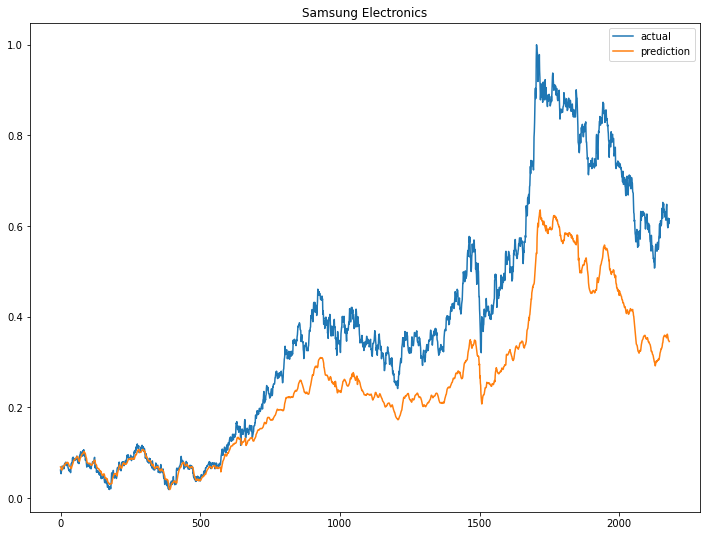

In [43]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.title('Samsung Electronics')

plt.legend()
plt.show()